## Processing the results after retraining and test of RO and ERO mts-LSTM networks

This code is for paper: "Precise Tuning of Regional Hydrological LSTM Networks: Simultaneous Systematic Random Search Optimization" by Hosseini et al. (in review)


In [1]:
"""
=================== Import required libraries ===================
"""

import csv
import ast
import os
import yaml
import pickle
import torch
import random
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import seaborn as sns
import more_itertools
import geopandas as gpd
import matplotlib as mpl
from pathlib import Path
from typing import Tuple
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
from matplotlib.image import imread

from matplotlib.colors import ListedColormap
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway



In [2]:
# 01 _ 01 - These variables are used during the experiment by the following codes

# The ten seeds that we trained all models on them. They were chosen randomly one time but then they were fixed for all the models
seeds = [970216, 846266, 931334, 723952, 893856, 339685, 64410, 202981, 105209, 370654]

# Read the basins list from the text file
with open(r'D:\Experiments\URA40basins_list.txt', 'r') as file:
    URA_basins = file.read().splitlines() # This is the list of all 40 basins that their data used to train all models

# Get a list of 25 basins that had verification data from 2000 to 2005 and were considered in the experiment and tests (We considered both streamflow and Water level as targets)
all_basins = ['Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Altzola', 'Amorebieta', 'Anarbe', 'Balmaseda',
              'Elorrio', 'Erenozu', 'Estanda', 'Gardea', 'Herrerias', 'Lasarte', 'Leitzaran', 'Muxika', 'Oiartzun', 'Onati', 
              'Otxandio', 'Sangroniz', 'Saratxo', 'Urkizu', 'Zaratamo'] # All of these basins have streamflow records

nolevel_basins      = ['Aitzu', 'Aixola', 'Aizarnazabal', 'Altzola',	'Anarbe', 'Erenozu', 'Leitzaran', 'Oiartzun'] # These basins do not have Water Level data records
URAnolevel_basins   = ['Abetxuko', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegria', 'Altzola',	'Anarbe', 'Arenao', 'Erenozu', 'Ibaieder', 'Leitzaran', 'Oiartzun', 'Sodupe'] # These basins do not have Water Level data records

# 10 Sample basins
Filtered_basins = ['Abusu', 'Aitzu', 'Aizarnazabal', 'Altzola', 'Amorebieta', 'Gardea', 'Lasarte', 'Leitzaran', 'Oiartzun', 'Sangroniz']

# Convert both lists to sets
URA_basins_set = set(URA_basins)
all_basins_set = set(all_basins)
nolevel_basins_set = set(nolevel_basins)
URAnolevel_basins_set = set(URAnolevel_basins)

# Obtain the difference (level basins)
level_basins_set    = all_basins_set - nolevel_basins_set
URAlevel_basins_set = URA_basins_set - URAnolevel_basins_set

# Convert the result back to a list
level_basins = sorted(list(level_basins_set))       # These are 17 basins that have water level records
URAlevel_basins = sorted(list(URAlevel_basins_set)) # These are 30 basins that have water level records
URA_basins = sorted(list(URA_basins_set)) # These are 30 basins that have water level records
all_basins = sorted(list(all_basins_set)) # These are 30 basins that have water level records
nolevel_basins = sorted(list(nolevel_basins_set)) # These are 30 basins that have water level records
URAnolevel_basins = sorted(list(URAnolevel_basins_set)) # These are 30 basins that have water level records

# Print or use the result
print('URA_basins:          ', '( are ', len(URA_basins),'   basins):', URA_basins)
print('all_basins:          ', '( are ', len(all_basins),'   basins):', all_basins)
print('level_basins:        ', '( are ', len(level_basins),'   basins):', level_basins)
print('nolevel_basins:      ', '( are ', len(nolevel_basins),'    basins):', nolevel_basins)
print('URAlevel_basins:     ', '( are ', len(URAlevel_basins),'   basins):', URAlevel_basins)
print('URAnolevel_basins:   ', '( are ', len(URAnolevel_basins),'   basins):', URAnolevel_basins)
print('Filtered_basins:     ', '( are ', len(Filtered_basins),'   basins):', Filtered_basins)

Model01 = 'Regional Optimal (RO)'
Model02 = 'Enhanced Regional Optimal (ERO)'

ERO_Filtered_basins = ['Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Alegria', 'Altzola', 'Amorebieta', 'Anarbe', 'Araxes', 'Arenao', 'Areta', 'Elorrio', 'Erenozu', 'Gatika', 'Herrerias', 'Jaizubia', 'Larrainazubi', 'Lasarte', 'Leitzaran', 'Markina', 'Muxika', 'Oiartzun', 'Onati', 'Otxandio', 'Ozaeta', 'SanPrudentzio', 'Sangroniz', 'Saratxo', 'Zaratamo']
RO_Filtered_basins = ['Sodupe', 'Urkizu', 'Abetxuko', 'Balmaseda', 'Eibar', 'Ibaieder', 'Estanda', 'Etura', 'Gardea']
Filtered_level_basins = ['Abusu', 'Agauntza', 'Alegia', 'Amorebieta', 'Araxes', 'Areta', 'Balmaseda', 'Eibar', 'Elorrio', 'Estanda', 'Etura', 'Gardea', 'Gatika', 'Herrerias', 'Jaizubia', 'Larrainazubi', 'Lasarte', 'Markina', 'Muxika', 'Onati', 'Otxandio', 'SanPrudentzio', 'Sangroniz', 'Saratxo', 'Urkizu', 'Zaratamo']


URA_basins:           ( are  40    basins): ['Abetxuko', 'Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Alegria', 'Altzola', 'Amorebieta', 'Anarbe', 'Araxes', 'Arenao', 'Areta', 'Balmaseda', 'Eibar', 'Elorrio', 'Erenozu', 'Estanda', 'Etura', 'Gardea', 'Gatika', 'Herrerias', 'Ibaieder', 'Jaizubia', 'Larrainazubi', 'Lasarte', 'Leitzaran', 'Markina', 'Muxika', 'Oiartzun', 'Onati', 'Otxandio', 'Ozaeta', 'SanPrudentzio', 'Sangroniz', 'Saratxo', 'Sodupe', 'Urkizu', 'Zaratamo']
all_basins:           ( are  25    basins): ['Abusu', 'Agauntza', 'Aitzu', 'Aixola', 'Aizarnazabal', 'Alegia', 'Altzola', 'Amorebieta', 'Anarbe', 'Balmaseda', 'Elorrio', 'Erenozu', 'Estanda', 'Gardea', 'Herrerias', 'Lasarte', 'Leitzaran', 'Muxika', 'Oiartzun', 'Onati', 'Otxandio', 'Sangroniz', 'Saratxo', 'Urkizu', 'Zaratamo']
level_basins:         ( are  17    basins): ['Abusu', 'Agauntza', 'Alegia', 'Amorebieta', 'Balmaseda', 'Elorrio', 'Estanda', 'Gardea', 'Herrerias', 'Lasarte', 'Muxika', 'Onati'

# Loaded Data names and list:

# RO Config after 100 Random Search
Regional_Optimal_RO:                       10 seeds for One_Fits_All_120 model:                      40 basins

Regional_Optimal_RO_metrics:               10 seeds metrics for One_Fits_All_120 model:              40 basins

# ERO Config after 1000 Random Search
Enhanced_Regional_Optimal_ERO:             10 seeds for One_Fits_All_1000 model:                     40 basins

Enhanced_Regional_Optimal_ERO_metrics:     10 seeds metrics for One_Fits_All_1000 model:             40 basins


In [3]:
# 01 _ 02 - This code loads all pickle files that will be used by the following codes

pickle_file_path1 = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\PickleFiles\RO_100RS_sims_seeds.p"                                # 10 seeds for One_Fits_All_120 model: 25 basins
pickle_file_path2 = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\PickleFiles\RO_100RS_sims_seeds_metrics.p"                        # 10 seeds metrics for One_Fits_All_120 model: 25 basins
pickle_file_path3 = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\PickleFiles\ERO_1000RS_sims_seeds.p"                              # 10 seeds for One_Fits_All_1000 model: 25 basins
pickle_file_path4 = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\PickleFiles\ERO_1000RS_sims_seeds_metrics.p"                      # 10 seeds metrics for One_Fits_All_1000 model: 25 basins
pickle_file_path_obs = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\PickleFiles\data_package_obs.p"                                # Test set Observatoions Pickle file

with open(pickle_file_path1, 'rb') as pickle_file:
    Regional_Optimal_RO = pickle.load(pickle_file)
with open(pickle_file_path2, 'rb') as pickle_file:
    Regional_Optimal_RO_metrics = pickle.load(pickle_file)
with open(pickle_file_path3, 'rb') as pickle_file:
    Enhanced_Regional_Optimal_ERO = pickle.load(pickle_file)
with open(pickle_file_path4, 'rb') as pickle_file:
    Enhanced_Regional_Optimal_ERO_metrics = pickle.load(pickle_file)
with open(pickle_file_path_obs, 'rb') as pickle_file:
    Obs_loaded = pickle.load(pickle_file)


# Comparison of the two networks performances

C:\Users\hosseinifh\AppData\Local\Temp\ipykernel_11272\807609322.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{y:.0f}' for y in ax.get_yticks()], fontsize=14)
C:\Users\hosseinifh\AppData\Local\Temp\ipykernel_11272\807609322.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{y:.0f}' for y in ax.get_yticks()], fontsize=14)
C:\Users\hosseinifh\AppData\Local\Temp\ipykernel_11272\807609322.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{y:.0f}' for y in ax.get_yticks()], fontsize=14)
C:\Users\hosseinifh\AppData\Local\Temp\ipykernel_11272\807609322.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usi

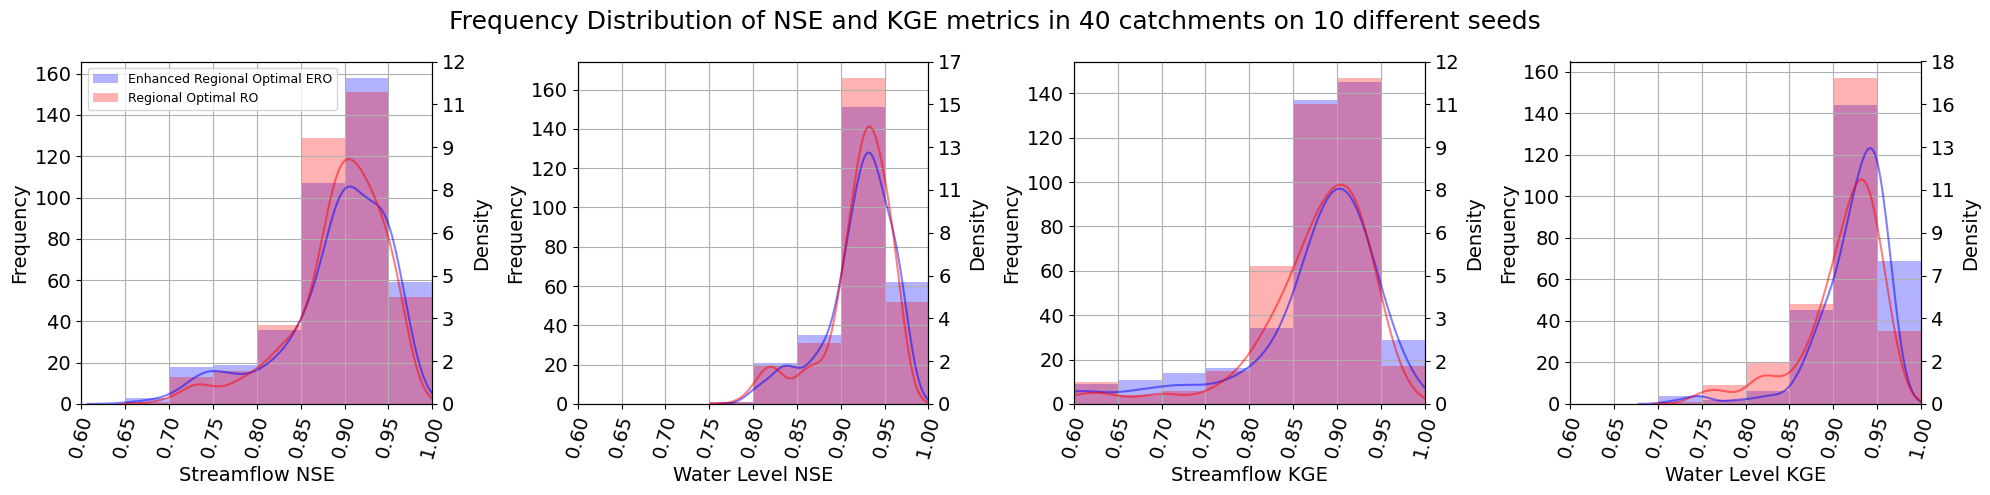

In [4]:

metrics = ['NSE', 'KGE']
variables = ['q_mean', 'l_mean']

# Create a 1x4 figure with four subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Frequency Distribution of NSE and KGE metrics in 40 catchments on 10 different seeds', fontsize=18)

handles = []
labels = []

# Iterate over each metric and variable combination
for i, (metric, variable) in enumerate([(m, v) for m in metrics for v in variables]):

    # Initialize a list to store all NSE values
    all_values_ERO = []
    all_values_RO = []

    if variable == 'l_mean':
        Basins = URAlevel_basins
    else:
        Basins = URA_basins

    # Iterate through the dictionary keys to extract NSE values for Regional Optimal RO
    for seed in Regional_Optimal_RO_metrics.keys():
        for basin in Basins:
            value = Regional_Optimal_RO_metrics[seed]['1H'][basin][variable][metric]
            all_values_RO.append(value)  # Append single float value

    # Iterate through the dictionary keys to extract NSE values for Enhanced Regional Optimal ERO
    for seed in Enhanced_Regional_Optimal_ERO_metrics.keys():
        for basin in Basins:
            value = Enhanced_Regional_Optimal_ERO_metrics[seed]['1H'][basin][variable][metric]
            all_values_ERO.append(value)  # Append single float value

    # Set bin edges
    max_values = [value for value in all_values_ERO + all_values_RO if not np.isnan(value)]
    bin_edges = [i * 0.05 for i in range(int(max(max_values) / 0.05) + 2)]

    # Plot histograms for Enhanced Regional Optimal ERO and Regional Optimal RO
    ax = axes[i]

    ax.hist(all_values_ERO, bins=bin_edges, alpha=0.3, color='blue', label=f'Enhanced Regional Optimal ERO')
    ax.hist(all_values_RO, bins=bin_edges, alpha=0.3, color='red', label=f'Regional Optimal RO')

    if variable == 'q_mean':
        ax.set_xlabel(f'Streamflow {metric}', fontsize=14)
    else:
        ax.set_xlabel(f'Water Level {metric}', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xlim(0.6, 1)
    if i == 0:
        handles_, labels_ = ax.get_legend_handles_labels()
        handles.extend(handles_)
        labels.extend(labels_)

        # ax.legend(fontsize=14)
    ax.grid(True)

    # Create a secondary y-axis for KDE plots
    ax2 = ax.twinx()
    ax2.set_ylabel('Density', fontsize=14)

    # Rescale KDE plot to fit within the range of histogram
    max_density = max(np.max(sns.kdeplot(all_values_ERO, color='blue', alpha=0.5).get_lines()[0].get_ydata()),
                      np.max(sns.kdeplot(all_values_RO, color='red', alpha=0.5).get_lines()[0].get_ydata())) + 1.5

    # Determine the range of data on the secondary y-axis
    min_value = 0  # Assuming the minimum value for the density is 0
    max_value = max_density +3 # Use the previously calculated max_density
    step_size = max_value / 8  # Adjust the number of ticks as needed

    # Set tick locations and labels for the secondary y-axis
    ax2.set_yticks(np.arange(min_value, max_value + step_size, step_size))
    ax2.set_yticklabels([f'{x:.0f}' for x in np.arange(min_value, max_value + step_size, step_size)], fontsize=14)

    # Set x-ticks every 0.1
    ax.set_xticks(np.arange(0.6, 1.01, 0.05))
    ax.set_xticklabels([f'{x:.2f}' for x in ax.get_xticks()], fontsize=14, rotation=75)
    ax.set_yticklabels([f'{y:.0f}' for y in ax.get_yticks()], fontsize=14)

    if i == 0:
        handles_, labels_ = ax.get_legend_handles_labels()
        handles.extend(handles_)
        labels.extend(labels_)
        ax.legend(loc='upper left', fontsize=9)

# Adjust layout
fig.tight_layout()

# Define the directory to save the plots
save_dir = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Figures"

# Save the plot to a file
save_path = os.path.join(save_dir, 'Test_Frequency_Distribution_plots.pdf')
plt.savefig(save_path, format='pdf', dpi=600)

plt.show()


C:\Users\hosseinifh\AppData\Local\Temp\ipykernel_11272\3788905156.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{y:.0f}' for y in ax.get_yticks()], fontsize=14)
C:\Users\hosseinifh\AppData\Local\Temp\ipykernel_11272\3788905156.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{y:.0f}' for y in ax.get_yticks()], fontsize=14)
C:\Users\hosseinifh\AppData\Local\Temp\ipykernel_11272\3788905156.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{y:.0f}' for y in ax.get_yticks()], fontsize=14)
C:\Users\hosseinifh\AppData\Local\Temp\ipykernel_11272\3788905156.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or

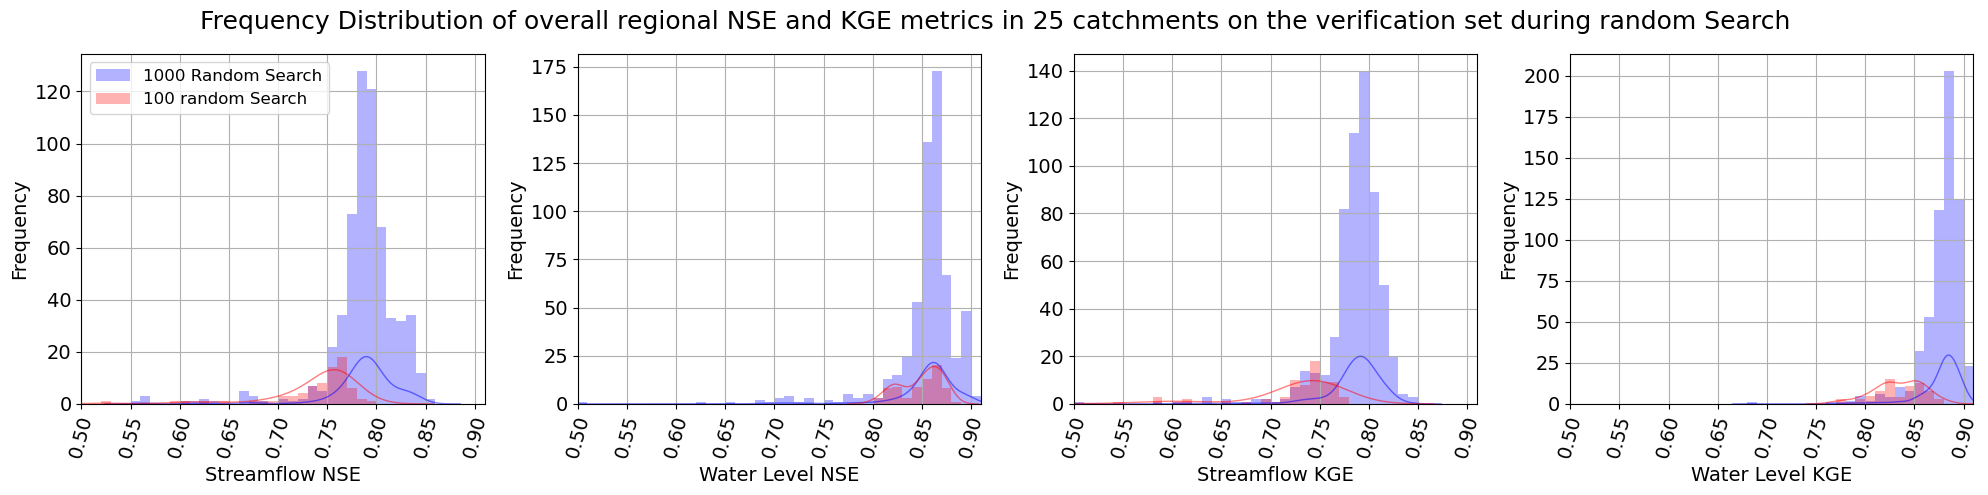

In [5]:
# File paths
file_1000 = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Results\1000_regional.xlsx"
file_100 = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Results\100_regional.xlsx"

# Read Excel files
df_1000 = pd.read_excel(file_1000)
df_100 = pd.read_excel(file_100)

metrics = ['NSE', 'KGE']
variables = ['q_mean', 'l_mean']

# Create a 1x4 figure with four subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Frequency Distribution of overall regional NSE and KGE metrics in 25 catchments on the verification set during random Search', fontsize=18)

handles = []
labels = []

# Iterate over each metric and variable combination
for i, (metric, variable) in enumerate([(m, v) for m in metrics for v in variables]):

    # Check metric and variable conditions to assign appropriate columns from the DataFrames
    if metric == 'NSE' and variable == 'q_mean':
        all_values_ERO = df_1000['SFmean_NSE']
        all_values_RO = df_100['SFmean_NSE']
    elif metric == 'KGE' and variable == 'q_mean':
        all_values_ERO = df_1000['SFmean_KGE']
        all_values_RO = df_100['SFmean_KGE']
    elif metric == 'NSE' and variable == 'l_mean':
        all_values_ERO = df_1000['WLmean_NSE']
        all_values_RO = df_100['WLmean_NSE']
    elif metric == 'KGE' and variable == 'l_mean':
        all_values_ERO = df_1000['WLmean_KGE']
        all_values_RO = df_100['WLmean_KGE']

    # Set bin edges
    max_values = [value for value in all_values_ERO + all_values_RO if not np.isnan(value)]
    bin_edges = [i * 0.01 for i in range(int(max(max_values) / 0.01) + 2)]

    # Plot histograms for Enhanced Regional Optimal ERO and Regional Optimal RO
    ax = axes[i]

    ax.hist(all_values_ERO, bins=bin_edges, alpha=0.3, color='blue', label=f'1000 Random Search')
    ax.hist(all_values_RO, bins=bin_edges, alpha=0.3, color='red', label=f'100 random Search')

    if variable == 'q_mean':
        ax.set_xlabel(f'Streamflow {metric}', fontsize=14)
    else:
        ax.set_xlabel(f'Water Level {metric}', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xlim(0.6, 0.91)
    if i == 0:
        handles_, labels_ = ax.get_legend_handles_labels()
        handles.extend(handles_)
        labels.extend(labels_)
        ax.legend(loc='upper left', fontsize=12)

    ax.grid(True)

    # Set x-ticks every 0.1
    ax.set_xticks(np.arange(0.5, 0.901, 0.05))
    ax.set_xticklabels([f'{x:.2f}' for x in ax.get_xticks()], fontsize=14, rotation=75)
    ax.set_yticklabels([f'{y:.0f}' for y in ax.get_yticks()], fontsize=14)

# Plot KDEs outside the loop to ensure they're plotted only once for each metric and variable combination
for i, (metric, variable) in enumerate([(m, v) for m in metrics for v in variables]):
    if metric == 'NSE' and variable == 'q_mean':
        all_values_ERO = df_1000['SFmean_NSE']
        all_values_RO = df_100['SFmean_NSE']
    elif metric == 'KGE' and variable == 'q_mean':
        all_values_ERO = df_1000['SFmean_KGE']
        all_values_RO = df_100['SFmean_KGE']
    elif metric == 'NSE' and variable == 'l_mean':
        all_values_ERO = df_1000['WLmean_NSE']
        all_values_RO = df_100['WLmean_NSE']
    elif metric == 'KGE' and variable == 'l_mean':
        all_values_ERO = df_1000['WLmean_KGE']
        all_values_RO = df_100['WLmean_KGE']
    ax = axes[i]
    kde_ero = sns.kdeplot(all_values_ERO, color='blue', linestyle='-', linewidth=1, label='Enhanced Regional Optimal ERO KDE', alpha=0.5, ax=ax)
    kde_ro = sns.kdeplot(all_values_RO, color='red', linestyle='-', linewidth=1, label='Regional Optimal RO KDE', alpha=0.5, ax=ax)

# Normalize the KDEs to match the histogram scale
for ax in axes:
    for line in ax.get_lines():
        y_scale = np.trapz(line.get_ydata(), line.get_xdata())
        line.set_ydata(line.get_ydata() / y_scale)

# Adjust layout
fig.tight_layout()

# Define the directory to save the plots
save_dir = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Figures"

# Save the plot to a file
save_path = os.path.join(save_dir, 'Frequency_Distribution_RandomSearch_regional.pdf')
plt.savefig(save_path, format='pdf', dpi=600)

plt.show()


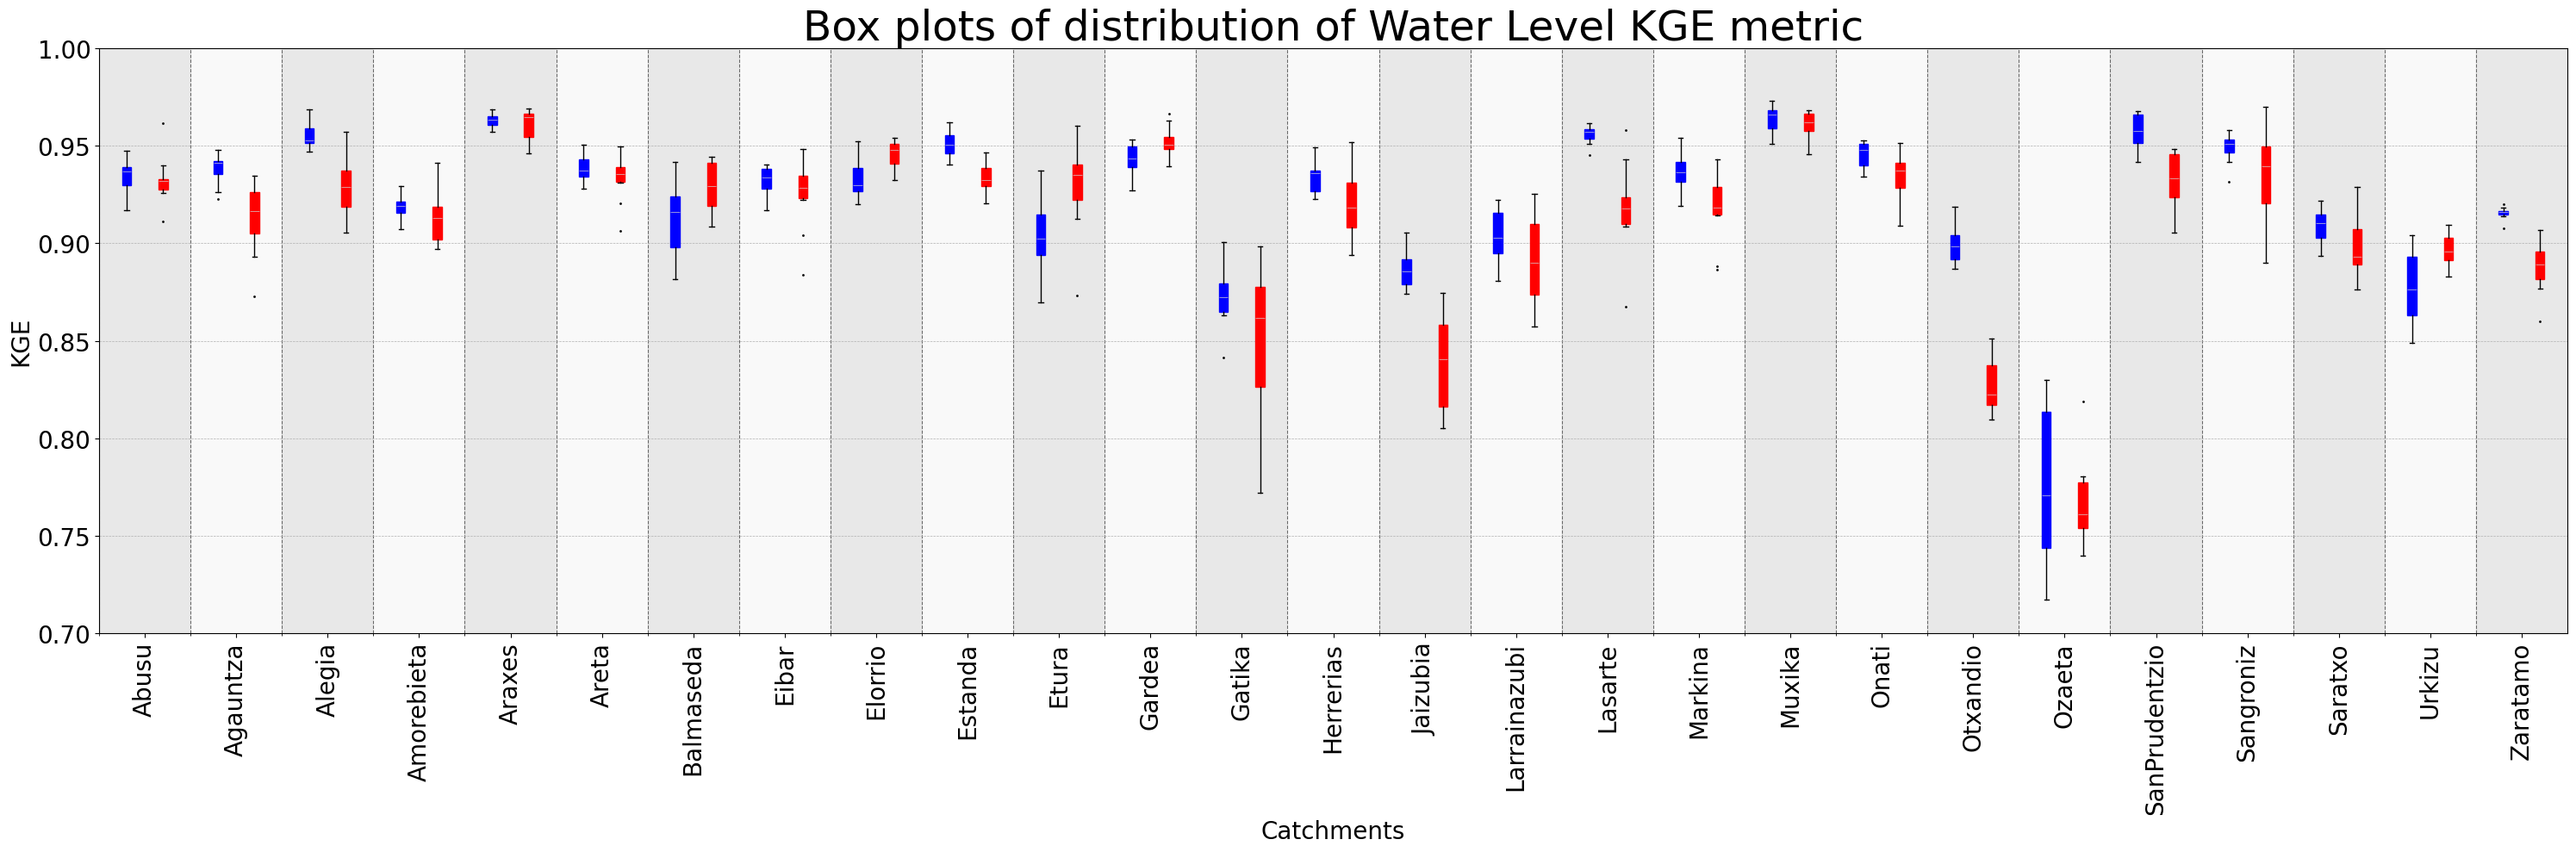

In [13]:
# 02 _ 00 - This code plots Box-plots for all seeds of all models in prallel for each of the Filtered_basins for showing on Paper (A sample of 10 basins to show results in a better visible way)

veriable = 'l_mean' # ['q_mean', 'q_inst', 'l_mean', 'l_inst']
metric = 'KGE'      # ['NSE', 'KGE', 'MSE', 'RMSE', 'Alpha-NSE', 'Beta-NSE', 'Beta-KGE', 'Pearson-r', 'FHV', 'FMS', 'FLV', 'Peak-Timing', 'Peak-MAPE', 'Missed-Peaks']
Basins = URAlevel_basins # URA_basins (40) or URAlevel_basins (26), Filtered_basins
hatch_patterns = ['-', '/', '\\', '|', '+', 'x', 'o']

data_One_fits_All_1000                  = {Basin: [] for Basin in Basins}
data_One_fits_All_120                   = {Basin: [] for Basin in Basins}

for seed in Enhanced_Regional_Optimal_ERO_metrics.keys():
    for Basin in Basins:
        data_One_fits_All_1000[Basin].append(Enhanced_Regional_Optimal_ERO_metrics[seed]["1H"][Basin][veriable][metric])

for seed in Regional_Optimal_RO_metrics.keys():
    for Basin in Basins:
        data_One_fits_All_120[Basin].append(Regional_Optimal_RO_metrics[seed]["1H"][Basin][veriable][metric])


# Initialize a list to store the data for each basin
boxplot_data_One_fits_All_1000                  = []
boxplot_data_One_fits_All_120                   = []

# Populate the boxplot_data list with the data for each basin
for Basin in Basins:
    boxplot_data_One_fits_All_1000.append(data_One_fits_All_1000[Basin])
for Basin in Basins:
    boxplot_data_One_fits_All_120.append(data_One_fits_All_120[Basin])

# Function to create box plots for each basin
def create_boxplots(ax, data, positions, color, label, hatch_pattern):
    ax.boxplot(data, positions=[positions], widths=0.1, patch_artist=True, boxprops=dict(facecolor=color, edgecolor=color, hatch=hatch_pattern), showmeans=False, labels=[label], flierprops=dict(marker='o', markersize=1, markerfacecolor='lightgray'), medianprops=dict(color='lightgray', linestyle='-', linewidth=0.5))

# Initialize figure and axis objects
fig, ax = plt.subplots(figsize=(30, 10))

# Set positions for the box plots
positions = np.arange(len(Basins))

# Set minor ticks between major ticks to customize gridlines
minor_ticks = np.arange(-0.5, len(Basins) - 0.5, 1)
ax.set_xticks(minor_ticks, minor=True)

# Show minor gridlines
ax.grid(which='minor', linestyle='--', linewidth='0.75', color='dimgray')

# Set Y-axis limits
ax.set_xlim(-0.5, 26.5)    # 39.5 for q_mean, 26.5 for l_mean   
# ax.set_ylim(0.75, 1)     # NSE  0.65 for q_mean, 0.75 for l_mean  
ax.set_ylim(0.7, 1)        # KGE  0.5 for q_mean, 0.7 for l_mean  
# ax.set_ylim(0, 0.008)     # MSE
# ax.set_ylim(0, 0.1)       # RMSE
# ax.set_ylim(0.8, 1.2)     # Alpha-NSE
# ax.set_ylim(0.8, 1.2)     # Beta-KGE
# ax.set_ylim(-0.075, 0.075)    # Beta-NSE
# ax.set_ylim(-20, 15)      # FHV
# ax.set_ylim(-40, 50)      # FMS
# ax.set_ylim(-5500, 200)   # FLV
# ax.set_ylim(0, 4)     # Peak-Timing
# ax.set_ylim(15, 40)   # Peak-MAPE
# ax.set_ylim(0.1, 0.45)   # Missed-Peaks

# # Shade the background between gridlines with alternating shades of gray
ax.fill_betweenx(ax.get_ylim(), -0.5, 0.5, color='lightgrey', alpha=0.5)    # ax.get_ylim()
ax.fill_betweenx(ax.get_ylim(), 0.5, 1.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 1.5, 2.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 2.5, 3.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 3.5, 4.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 4.5, 5.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 5.5, 6.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 6.5, 7.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 7.5, 8.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 8.5, 9.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 9.5, 10.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 10.5, 11.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 11.5, 12.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 12.5, 13.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 13.5, 14.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 14.5, 15.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 15.5, 16.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 16.5, 17.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 17.5, 18.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 18.5, 19.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 19.5, 20.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 20.5, 21.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 21.5, 22.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 22.5, 23.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 23.5, 24.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 24.5, 25.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 25.5, 26.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 26.5, 27.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 27.5, 28.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 28.5, 29.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 29.5, 30.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 30.5, 31.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 31.5, 32.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 32.5, 33.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 33.5, 34.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 34.5, 35.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 35.5, 36.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 36.5, 37.5, color='whitesmoke', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 37.5, 38.5, color='lightgrey', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 38.5, 39.5, color='whitesmoke', alpha=0.5)

# Iterate over each basin and plot the box plots side by side
for i, basin in enumerate(Basins):
    
    # Calculate positions for parallel plots
    position01 = i - 0.2
    position02 = i + 0.2
    
    # Plot box plots for All_Basin_specific_HPs, Basin_specific_HPs, One_fits_All_1000, One_fits_All_120, and One_fits_All_1000_Kmeans
    create_boxplots(ax, boxplot_data_One_fits_All_1000[i],                  position01, 'blue', f'{basin}', hatch_patterns[2])
    create_boxplots(ax, boxplot_data_One_fits_All_120[i],                   position02, 'red', f'{basin}', hatch_patterns[4])

# Set x-axis labels and rotate for better readability
ax.set_xticks(np.arange(len(Basins)))
ax.set_xticklabels(Basins, rotation=90)

# Set title and labels
ax.set_title(f'Box plots of distribution of Water Level {metric} metric', fontsize=35)  # Water Level or Streamflow
ax.set_xlabel('Catchments', fontsize=20)
ax.set_ylabel(f'{metric}', fontsize=20)

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color='blue', label='Enhanced Regional Optimal (ERO) (10 seeds simulations)'),
    mpatches.Patch(color='red', label='Regional Optimal (RO) (10 seeds simulations)')
]

Model01 = 'Regional Optimal (RO)'
Model02 = 'Enhanced Regional Optimal (ERO)'

# Set y-axis major gridlines every 0.1 units
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5)

# Add a horizontal line at y=1
# ax.axhline(y=0, color='red', linestyle='--')    # FLV   FMS     FHV     Beta-NSE
# ax.axhline(y=1, color='red', linestyle='--')    # Beta-KGE    Alpha-NSE

# Add legend to the plot
# plt.legend(handles=legend_patches, loc='lower left', bbox_to_anchor=(0.03, 0.05), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adjust layout
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"...\Supplementary_materials\Figures"

# Save the plot to a file
save_path = os.path.join(save_dir, f'{metric}_{veriable}_box_plot_40Basins.png')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, dpi=300)

# Show the plot
plt.show()


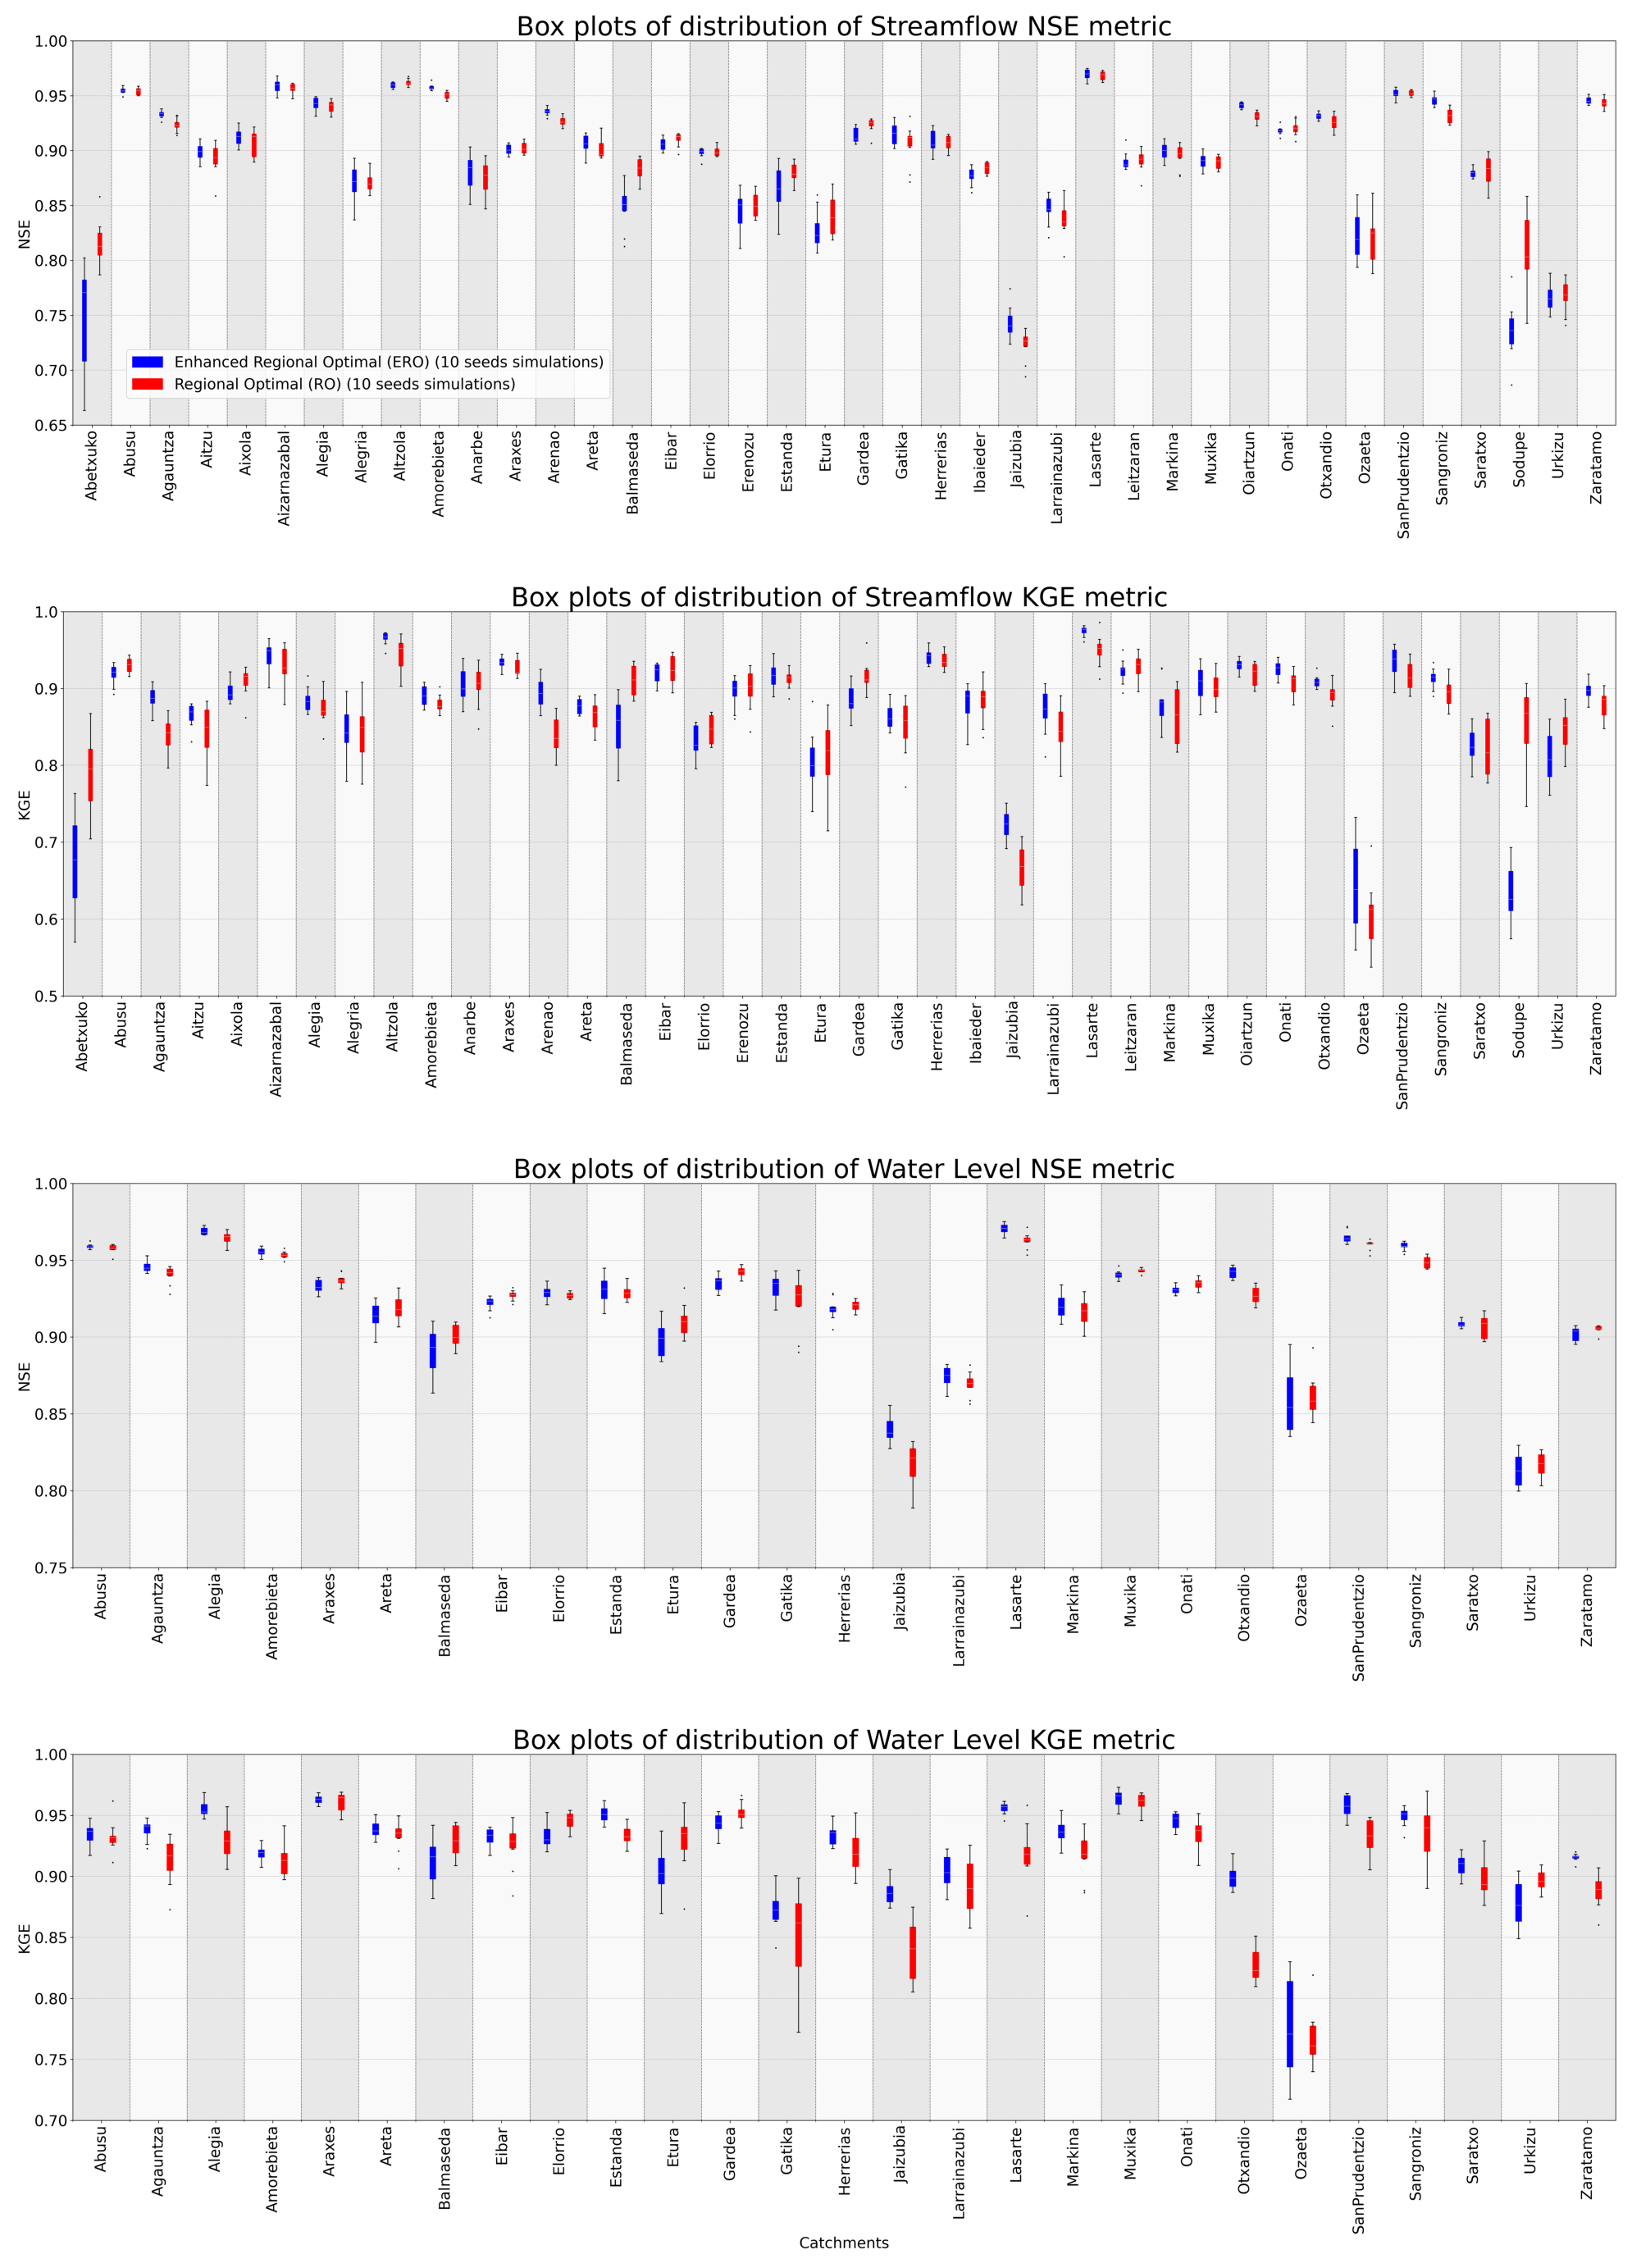

In [6]:
## This code combines all 4 figures for the paper

# Load your figures
fig_paths = [
    r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Figures\NSE_q_mean_box_plot_40Basins.png",
    r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Figures\KGE_q_mean_box_plot_40Basins.png",
    r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Figures\NSE_l_mean_box_plot_40Basins.png",
    r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Figures\KGE_l_mean_box_plot_40Basins.png"
]

# Create a 4x1 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 28))

# Loop through each subplot and add the corresponding figure
for i, ax in enumerate(axes):
    img = imread(fig_paths[i])
    ax.imshow(img)
    ax.axis('off')  # Hide axis labels

# Adjust layout to prevent overlap
plt.tight_layout()

# Define the directory to save the plots
save_dir = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Figures"

# Save the plot to a file
save_path = os.path.join(save_dir, f'combined_figures.pdf')
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create folder if it doesn't exist
plt.savefig(save_path, format='pdf', dpi=600)
plt.show()  # Display the combined figure


In [7]:
# The following will be used to plot next figures

variables = ['q_mean', 'l_mean']
metrics = ['NSE', 'KGE']      

data_One_fits_All_1000 = {}
data_One_fits_All_100 = {}

for variable in variables:
    for metric in metrics:
        if variable == 'l_mean':
            Basins = URAlevel_basins
        else:
            Basins = URA_basins

        if variable not in data_One_fits_All_1000:
            data_One_fits_All_1000[variable] = {}
        if variable not in data_One_fits_All_100:
            data_One_fits_All_100[variable] = {}

        data_One_fits_All_1000[variable][metric] = {Basin: [] for Basin in Basins}
        data_One_fits_All_100[variable][metric] = {Basin: [] for Basin in Basins}

        for seed in Enhanced_Regional_Optimal_ERO_metrics.keys():
            for Basin in Basins:
                data_One_fits_All_1000[variable][metric][Basin].append(Enhanced_Regional_Optimal_ERO_metrics[seed]["1H"][Basin][variable][metric])

        for seed in Regional_Optimal_RO_metrics.keys():
            for Basin in Basins:
                data_One_fits_All_100[variable][metric][Basin].append(Regional_Optimal_RO_metrics[seed]["1H"][Basin][variable][metric])

cdfplot_data_One_fits_All_1000 = {}
cdfplot_data_One_fits_All_100 = {}

for variable in variables:
    for metric in metrics:
        if variable not in cdfplot_data_One_fits_All_1000:
            cdfplot_data_One_fits_All_1000[variable] = {}
        if variable not in cdfplot_data_One_fits_All_100:
            cdfplot_data_One_fits_All_100[variable] = {}

        # Initialize a dictionary to store the data for each basin
        cdfplot_data_One_fits_All_1000[variable][metric] = {i: [] for i in range(10)}
        cdfplot_data_One_fits_All_100[variable][metric] = {i: [] for i in range(10)}

        # Populate the cdfplot_data dictionaries with the data for each basin
        for i in range(10):
            for Basin in Basins:
                cdfplot_data_One_fits_All_1000[variable][metric][i].append(data_One_fits_All_1000[variable][metric][Basin][i])
                cdfplot_data_One_fits_All_100[variable][metric][i].append(data_One_fits_All_100[variable][metric][Basin][i])


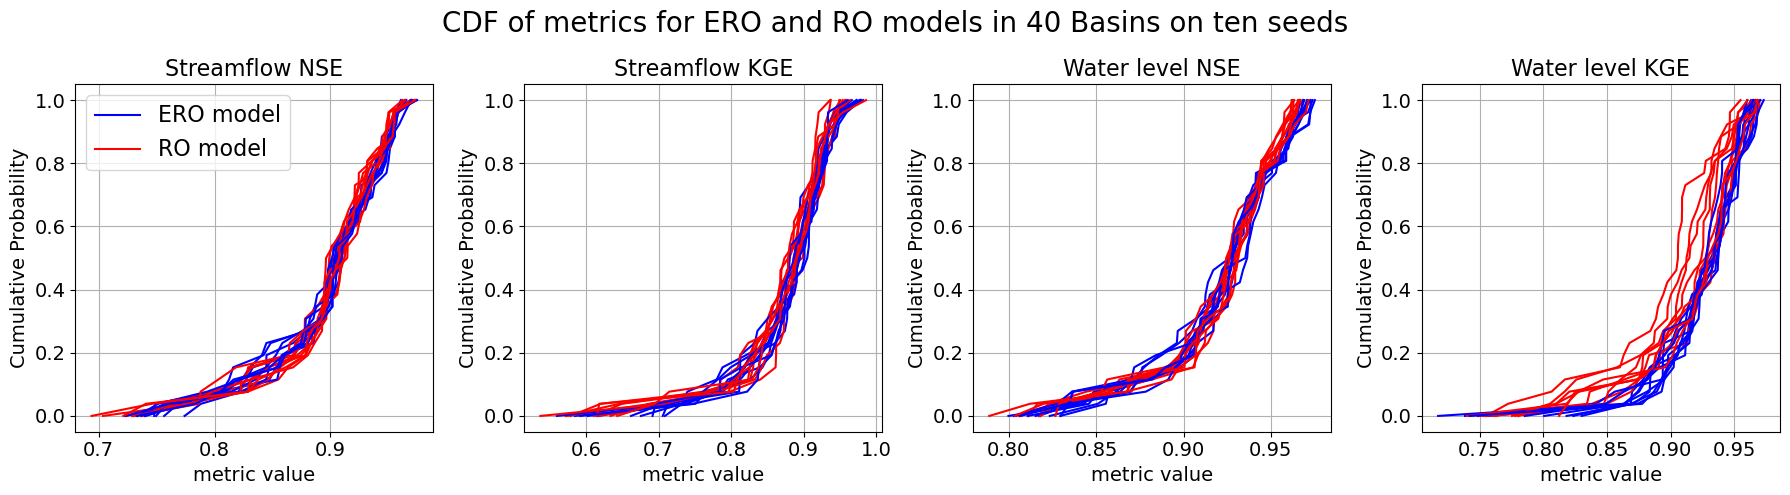

In [8]:
# Function to plot CDF for each variable with specified colors
def plot_cdfs(data1, data2, title, ax, color1, color2, legend):
    for i in range(10):
        sorted_data1 = np.sort(data1[i])
        yvals1 = np.arange(len(sorted_data1)) / float(len(sorted_data1) - 1)
        sorted_data2 = np.sort(data2[i])
        yvals2 = np.arange(len(sorted_data2)) / float(len(sorted_data2) - 1)
        if i == 0:
            ax.plot(sorted_data1, yvals1, linestyle='-', color=color1, label=f'ERO model')
            ax.plot(sorted_data2, yvals2, linestyle='-', color=color2, label=f'RO model')
        else:
            ax.plot(sorted_data1, yvals1, linestyle='-', color=color1)
            ax.plot(sorted_data2, yvals2, linestyle='-', color=color2)
    ax.set_xlabel('metric value', fontsize=14)
    ax.set_ylabel('Cumulative Probability', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    if legend == 1:
        ax.legend(fontsize=16)

# Define the number of rows and columns for the subplots
num_rows = 1
num_cols = 4

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5))

# Plot CDF for ERO in blue and RO in red
plot_cdfs(cdfplot_data_One_fits_All_1000['q_mean']['NSE'], cdfplot_data_One_fits_All_100['q_mean']['NSE'], 'Streamflow NSE', axs[0], 'blue', 'red', 1)
plot_cdfs(cdfplot_data_One_fits_All_1000['q_mean']['KGE'], cdfplot_data_One_fits_All_100['q_mean']['KGE'], 'Streamflow KGE', axs[1], 'blue', 'red', 0)
plot_cdfs(cdfplot_data_One_fits_All_1000['l_mean']['NSE'], cdfplot_data_One_fits_All_100['l_mean']['NSE'], 'Water level NSE', axs[2], 'blue', 'red', 0)
plot_cdfs(cdfplot_data_One_fits_All_1000['l_mean']['KGE'], cdfplot_data_One_fits_All_100['l_mean']['KGE'], 'Water level KGE', axs[3], 'blue', 'red', 0)

# Add title to the main figure
fig.suptitle('CDF of metrics for ERO and RO models in 40 Basins on ten seeds', fontsize=20)

# Adjust layout
plt.tight_layout()

# Define the directory to save the plots
os.makedirs(save_dir, exist_ok=True)  # Create folder if it doesn't exist

# Save the plot to a file
save_path = os.path.join(save_dir, 'cdf_plots_40Basins.pdf')
plt.savefig(save_path, format='pdf', dpi=600)

plt.show()


# Statistical tests

In [9]:

# Load the Excel file into a DataFrame

file_path_RO = r'D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Results\RO.metrics.xlsx'
file_path_ERO = r'D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Results\ERO.metrics.xlsx'
df_RO = pd.read_excel(file_path_RO)
df_ERO = pd.read_excel(file_path_ERO)

# Extract relevant columns
df_regional_RO_NSE_SF   = df_RO[['basin', 'seed', 'SFmean_NSE']]
df_regional_RO_KGE_SF   = df_RO[['basin', 'seed', 'SFmean_KGE']]
df_regional_ERO_NSE_SF  = df_ERO[['basin', 'seed', 'SFmean_NSE']]
df_regional_ERO_KGE_SF  = df_ERO[['basin', 'seed', 'SFmean_KGE']]
df_regional_RO_NSE_WL   = df_RO[['basin', 'seed', 'WLmean_NSE']]
df_regional_RO_KGE_WL   = df_RO[['basin', 'seed', 'WLmean_KGE']]
df_regional_ERO_NSE_WL  = df_ERO[['basin', 'seed', 'WLmean_NSE']]
df_regional_ERO_KGE_WL  = df_ERO[['basin', 'seed', 'WLmean_KGE']]

# Pivot the DataFrame to get the desired structure
df_regional_RO_NSE_SF   = df_regional_RO_NSE_SF.pivot_table(index='basin', columns='seed', values='SFmean_NSE', aggfunc='mean')
df_regional_RO_KGE_SF   = df_regional_RO_KGE_SF.pivot_table(index='basin', columns='seed', values='SFmean_KGE', aggfunc='mean')
df_regional_ERO_NSE_SF  = df_regional_ERO_NSE_SF.pivot_table(index='basin', columns='seed', values='SFmean_NSE', aggfunc='mean')
df_regional_ERO_KGE_SF  = df_regional_ERO_KGE_SF.pivot_table(index='basin', columns='seed', values='SFmean_KGE', aggfunc='mean')
df_regional_RO_NSE_WL   = df_regional_RO_NSE_WL.pivot_table(index='basin', columns='seed', values='WLmean_NSE', aggfunc='mean')
df_regional_RO_KGE_WL   = df_regional_RO_KGE_WL.pivot_table(index='basin', columns='seed', values='WLmean_KGE', aggfunc='mean')
df_regional_ERO_NSE_WL  = df_regional_ERO_NSE_WL.pivot_table(index='basin', columns='seed', values='WLmean_NSE', aggfunc='mean')
df_regional_ERO_KGE_WL  = df_regional_ERO_KGE_WL.pivot_table(index='basin', columns='seed', values='WLmean_KGE', aggfunc='mean')


In [10]:
## Code to run statistical tests between metrics of the two different configurations of RO and ERO 
## for distribution of ten different metrics/targets on each random seeds that they were trained
## We apllied three different statistical tests and we found that maybe some test types on the final outcomes

def cm2inch(width: float, height: float) -> Tuple[float, float]:
    """Converts figure size from centimeters to inch."""
    inch = 2.54
    return (width / inch, height / inch)

def Wilcoxon_signed_rank(df_01, df_02, Basins, alpha=0.05):
    new_better = []
    old_better = []
    both_equal = []
    
    for basin in Basins:
        old_values = df_01.loc[basin].values
        new_values = df_02.loc[basin].values
        _, p_value = wilcoxon(old_values, new_values)

        if (p_value < alpha) and (np.mean(old_values) > np.mean(new_values)):
            old_better.append(basin)
        elif (p_value < alpha) and (np.mean(old_values) < np.mean(new_values)):
            new_better.append(basin)
        else:
            both_equal.append(basin)
        
    return {'statistically different (worse)': old_better, 'statistically different (better)': new_better, 'not statistically different': both_equal}

def Mann_Whitney_U(df_01, df_02, Basins, alpha=0.05):
    new_better = []
    old_better = []
    both_equal = []
    
    for basin in Basins:
        old_values = df_01.loc[basin].values
        new_values = df_02.loc[basin].values
        _, p_value = mannwhitneyu(old_values, new_values)

        if (p_value < alpha) and (np.mean(old_values) > np.mean(new_values)):
            old_better.append(basin)
        elif (p_value < alpha) and (np.mean(old_values) < np.mean(new_values)):
            new_better.append(basin)
        else:
            both_equal.append(basin)
        
    return {'statistically different (worse)': old_better, 'statistically different (better)': new_better, 'not statistically different': both_equal}

def ANOVA(df_01, df_02, Basins, alpha=0.05):
    new_better = []
    old_better = []
    both_equal = []
    
    for basin in Basins:
        old_values = df_01.loc[basin].values
        new_values = df_02.loc[basin].values
        _, p_value = f_oneway(old_values, new_values)

        if (p_value < alpha) and (np.mean(old_values) > np.mean(new_values)):
            old_better.append(basin)
        elif (p_value < alpha) and (np.mean(old_values) < np.mean(new_values)):
            new_better.append(basin)
        else:
            both_equal.append(basin)
        
    return {'statistically different (worse)': old_better, 'statistically different (better)': new_better, 'not statistically different': both_equal}


In [11]:
# Performing Statistical Tests

approach_to_compared_models = {}

approach_to_compared_models["Wilcoxon_signed_rank_NSE_SF"] = Wilcoxon_signed_rank(df_regional_RO_NSE_SF, df_regional_ERO_NSE_SF, URA_basins)
approach_to_compared_models["Wilcoxon_signed_rank_KGE_SF"] = Wilcoxon_signed_rank(df_regional_RO_KGE_SF, df_regional_ERO_KGE_SF, URA_basins)
approach_to_compared_models["Mann_Whitney_U_NSE_SF"] = Mann_Whitney_U(df_regional_RO_NSE_SF, df_regional_ERO_NSE_SF, URA_basins)
approach_to_compared_models["Mann_Whitney_U_KGE_SF"] = Mann_Whitney_U(df_regional_RO_KGE_SF, df_regional_ERO_KGE_SF, URA_basins)
approach_to_compared_models["ANOVA_NSE_SF"] = ANOVA(df_regional_RO_NSE_SF, df_regional_ERO_NSE_SF, URA_basins)
approach_to_compared_models["ANOVA_KGE_SF"] = ANOVA(df_regional_RO_KGE_SF, df_regional_ERO_KGE_SF, URA_basins)

approach_to_compared_models["Wilcoxon_signed_rank_NSE_WL"] = Wilcoxon_signed_rank(df_regional_RO_NSE_WL, df_regional_ERO_NSE_WL, URAlevel_basins)
approach_to_compared_models["Wilcoxon_signed_rank_KGE_WL"] = Wilcoxon_signed_rank(df_regional_RO_KGE_WL, df_regional_ERO_KGE_WL, URAlevel_basins)
approach_to_compared_models["Mann_Whitney_U_NSE_WL"] = Mann_Whitney_U(df_regional_RO_NSE_WL, df_regional_ERO_NSE_WL, URAlevel_basins)
approach_to_compared_models["Mann_Whitney_U_KGE_WL"] = Mann_Whitney_U(df_regional_RO_KGE_WL, df_regional_ERO_KGE_WL, URAlevel_basins)
approach_to_compared_models["ANOVA_NSE_WL"] = ANOVA(df_regional_RO_NSE_WL, df_regional_ERO_NSE_WL, URAlevel_basins)
approach_to_compared_models["ANOVA_KGE_WL"] = ANOVA(df_regional_RO_KGE_WL, df_regional_ERO_KGE_WL, URAlevel_basins)


In [12]:
## These are going to be used by next codes

x_order = ['Wilcoxon_signed_rank_NSE_SF', 'Mann_Whitney_U_NSE_SF',  'ANOVA_NSE_SF',
           'Wilcoxon_signed_rank_KGE_SF', 'Mann_Whitney_U_KGE_SF',  'ANOVA_KGE_SF',
           'Wilcoxon_signed_rank_NSE_WL', 'Mann_Whitney_U_NSE_WL',  'ANOVA_NSE_WL',
           'Wilcoxon_signed_rank_KGE_WL', 'Mann_Whitney_U_KGE_WL',  'ANOVA_KGE_WL']
approach_to_label = {
    'Wilcoxon_signed_rank_NSE_SF': 'Wilcoxon signed rank NSE SF',
    'Mann_Whitney_U_NSE_SF': 'Mann Whitney U NSE SF',
    'ANOVA_NSE_SF': 'ANOVA NSE SF',
    'Wilcoxon_signed_rank_KGE_SF': 'Wilcoxon signed rank KGE SF',
    'Mann_Whitney_U_KGE_SF': 'Mann Whitney U KGE SF',
    'ANOVA_KGE_SF': 'ANOVA KGE SF',
    'Wilcoxon_signed_rank_NSE_WL': 'Wilcoxon signed rank NSE WL',
    'Mann_Whitney_U_NSE_WL': 'Mann Whitney U NSE WL',
    'ANOVA_NSE_WL': 'ANOVA NSE WL',
    'Wilcoxon_signed_rank_KGE_WL': 'Wilcoxon signed rank KGE WL',
    'Mann_Whitney_U_KGE_WL': 'Mann Whitney U KGE WL',
    'ANOVA_KGE_WL': 'ANOVA KGE WL',
}


In [13]:
# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=["Basin"] + x_order)

# Iterate over basins and update the DataFrame with better or worse classification
row_data_list = []
for basin in URA_basins:
    row_data = {"Basin": basin}
    for approach in x_order:
        better_count = len(approach_to_compared_models[approach]["statistically different (better)"])
        worse_count = len(approach_to_compared_models[approach]["statistically different (worse)"])
        no_diff_count = len(approach_to_compared_models[approach]["not statistically different"])
        if basin in approach_to_compared_models[approach]["statistically different (better)"]:
            row_data[approach] = "Better"
        elif basin in approach_to_compared_models[approach]["statistically different (worse)"]:
            row_data[approach] = "Worse"
        elif basin in approach_to_compared_models[approach]["not statistically different"]:
            row_data[approach] = "No difference"
        else:
            row_data[approach] = ""
    row_data_list.append(row_data)

results_df = pd.concat([results_df, pd.DataFrame(row_data_list)], ignore_index=True)

# Save the DataFrame to Excel
results_df.to_excel(os.path.join(save_dir, 'basin_classification_results.xlsx'), index=False)


In [14]:
# Read the Excel file
file_path = r"D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Figures\basin_classification_results.xlsx"
df = pd.read_excel(file_path)

# Select only the required columns
selected_cols = ['Basin', 
                 'Wilcoxon_signed_rank_NSE_SF', 'Mann_Whitney_U_NSE_SF', 'ANOVA_NSE_SF', 
                 'Wilcoxon_signed_rank_KGE_SF', 'Mann_Whitney_U_KGE_SF', 'ANOVA_KGE_SF', 
                 'Wilcoxon_signed_rank_NSE_WL', 'Mann_Whitney_U_NSE_WL', 'ANOVA_NSE_WL', 
                 'Wilcoxon_signed_rank_KGE_WL', 'Mann_Whitney_U_KGE_WL', 'ANOVA_KGE_WL']

df_selected = df[selected_cols].copy()  # Create a copy of the DataFrame

# Define a function to map the values to -1, 0, or 1
def map_value(value):
    if value == 'Worse':
        return -1
    elif value == 'No difference':
        return 0
    elif value == 'Better':
        return 1
    else:
        return np.nan

# Apply the mapping function to the selected columns
for col in selected_cols[1:]:  # Exclude 'Basin' column
    df_selected[col] = df_selected[col].apply(map_value)

# Define the columns to consider for sorting
sort_cols = ['Wilcoxon_signed_rank_NSE_SF', 'Mann_Whitney_U_NSE_SF', 'ANOVA_NSE_SF',
             'Wilcoxon_signed_rank_KGE_SF', 'Mann_Whitney_U_KGE_SF', 'ANOVA_KGE_SF',
             'Wilcoxon_signed_rank_NSE_WL', 'Mann_Whitney_U_NSE_WL', 'ANOVA_NSE_WL',
             'Wilcoxon_signed_rank_KGE_WL', 'Mann_Whitney_U_KGE_WL', 'ANOVA_KGE_WL']

# Calculate the sum across the specified columns
df_selected['sum'] = df_selected[sort_cols].sum(axis=1)

# Sort the DataFrame based on the sum column
df_sorted = df_selected.sort_values(by=['sum'], ascending=False)

# Separate the rows with more +1 values
df_positive = df_sorted[df_sorted['sum'] > 0].copy()

# Separate the rows with more -1 values
df_negative = df_sorted[df_sorted['sum'] < 0].copy()

# Separate the rows with all zeros
df_zeros = df_sorted[df_sorted['sum'] == 0].copy()

# Concatenate the DataFrames in the desired order
df_final = pd.concat([df_positive, df_negative, df_zeros])

# Drop the temporary sum column
df_final.drop(columns=['sum'], inplace=True)

# Save the sorted DataFrame to a new Excel file
output_sorted_file_path = os.path.join(save_dir, 'Data.xlsx')
df_final.to_excel(output_sorted_file_path, index=False)


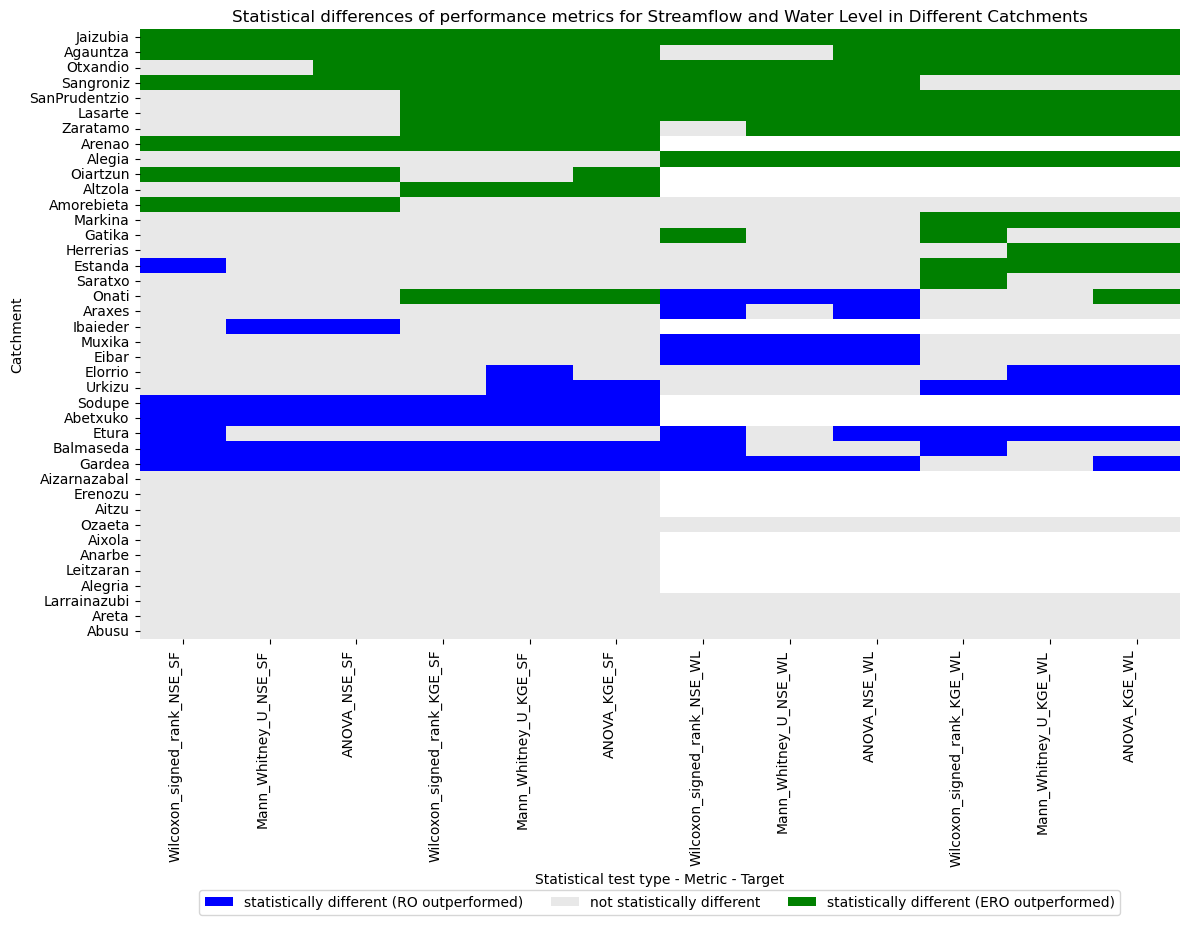

In [15]:

# Read the modified CSV file
data = pd.read_excel(r'D:\Thesis2024\Papers.OnGoing\Papers.UnderWork\Paper.01.01.RandomSearch.SHpT.URA\Supplementary_materials\Figures\Data.xlsx', index_col='Basin')

# Define the colors with alpha values
colors = ['blue', '#E8E8E8', 'green']

# Create the custom color map
cmap = ListedColormap(colors)

# Create the heatmap with reversed colors
plt.figure(figsize=(12, 10))
sns.heatmap(data, cmap=cmap, cbar=False)  # Remove the color bar
plt.title('Statistical differences of performance metrics for Streamflow and Water Level in Different Catchments')
plt.xlabel('Statistical test type - Metric - Target')
plt.ylabel('Catchment')
plt.xticks(rotation=90, ha='right')

# Add custom legend
legend_labels = ['statistically different (RO outperformed)', 'not statistically different', 'statistically different (ERO outperformed)']
patches = [plt.Rectangle((0,0),1,1,fc=color) for color in colors]
plt.legend(patches, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)

plt.tight_layout()

# Save the figure
plt.savefig(
    os.path.join(save_dir, f'stats_fig.pdf'),
    format='pdf',
    dpi=600,
    bbox_inches='tight'
)

plt.show()


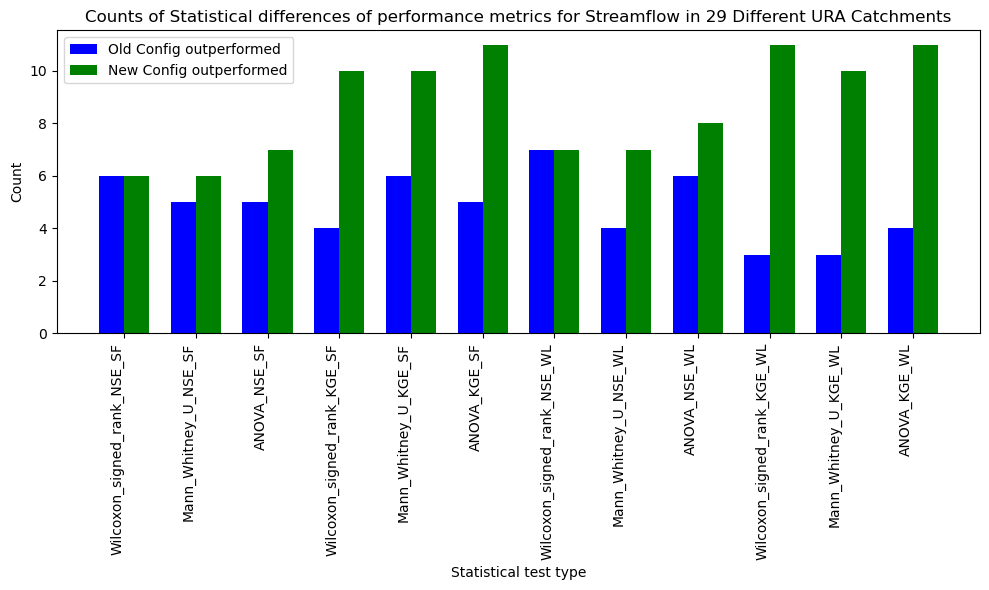

In [16]:

# Calculate the counts of blue and green colors for each test
blue_counts = (data == -1).sum()
green_counts = (data == 1).sum()

# Plot the bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(blue_counts))

plt.bar(index, blue_counts, bar_width, label='Old Config outperformed', color='blue')
plt.bar(index + bar_width, green_counts, bar_width, label='New Config outperformed', color='green')

plt.xlabel('Statistical test type')
plt.ylabel('Count')
plt.title('Counts of Statistical differences of performance metrics for Streamflow in 29 Different URA Catchments')
plt.xticks(index + bar_width / 2, data.columns, rotation=90, ha='right')
plt.legend()

plt.tight_layout()

# Save the figure
plt.savefig(
    os.path.join(save_dir, f'stats_fig_counts_URA.pdf'),
    format='pdf',
    dpi=600, 
    bbox_inches='tight'  
)

plt.show()
